# Hierarchical clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

## Analyzing a dendrogram

A dendrogram is a tree data structure that allows us to represent the entire clustering hierarchy
produced by either an agglomerative or divisive algorithm. The idea is to put the samples on the x axis and the dissimilarity level on the y axis. Whenever two clusters are merged, the dendrogram shows a connection corresponding to the dissimilarity level at which it occurred. Hence, in an agglomerative scenario, a dendrogram always starts with all samples considered as clusters and moves upward (the direction is purely conventional) until a single cluster is defined.

Let's consider a small dataset, X, made up of 12 bidimensional samples generated by 4 Gaussian
distributions with mean vectors in the range (-1, 1) × (-1, 1):

In [2]:
np.random.seed(1000)

nb_samples = 12
nb_centers = 4

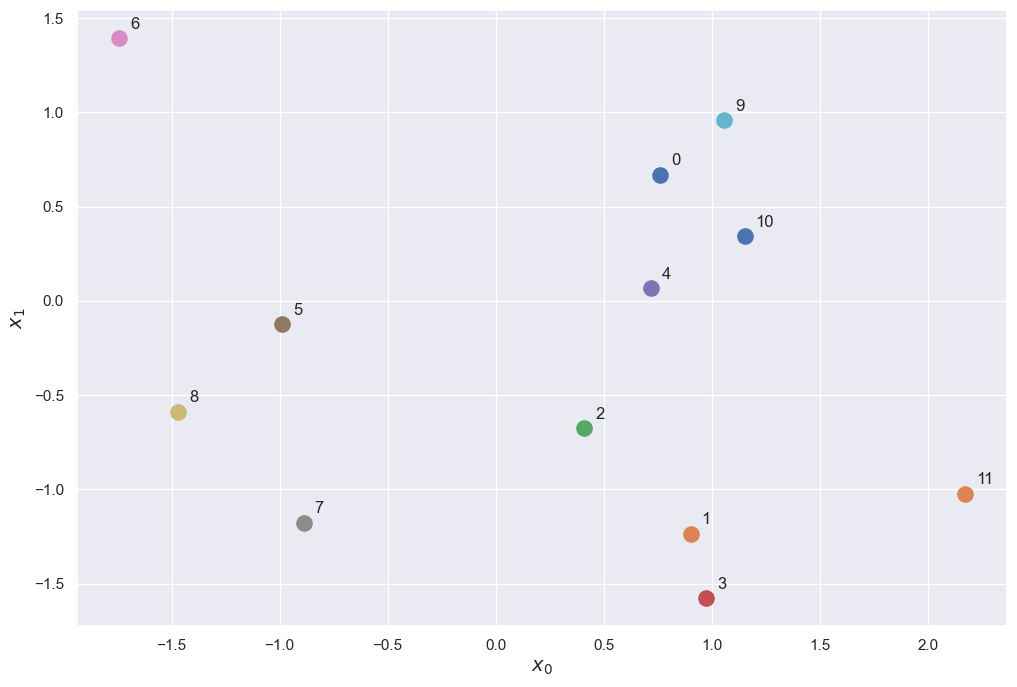

In [3]:
# Create the dataset
X, Y = make_blobs(n_samples=nb_samples, n_features=2, center_box=[-1, 1], centers=nb_centers, random_state=1000)

# Show the dataset
sns.set()

fig, ax = plt.subplots(figsize=(12, 8))

for i, x in enumerate(X):
    ax.scatter(x[0], x[1], s=120)
    ax.annotate('%d' % i, xy=(x[0] + 0.05, x[1] + 0.05), fontsize=12)

ax.set_xlabel(r'$x_0$', fontsize=14)
ax.set_ylabel(r'$x_1$', fontsize=14)

plt.show()

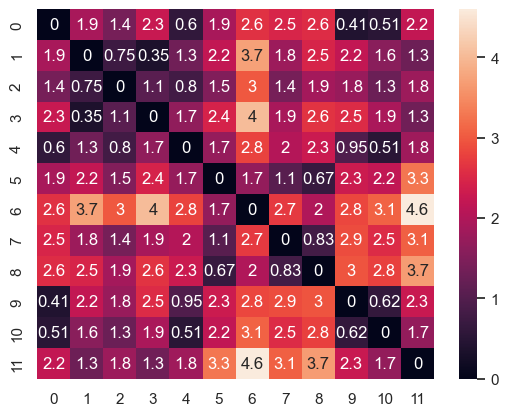

In [4]:
# Compute the distance matrix
dm = pdist(X, metric='euclidean')
sns.heatmap(squareform(dm), annot=True);

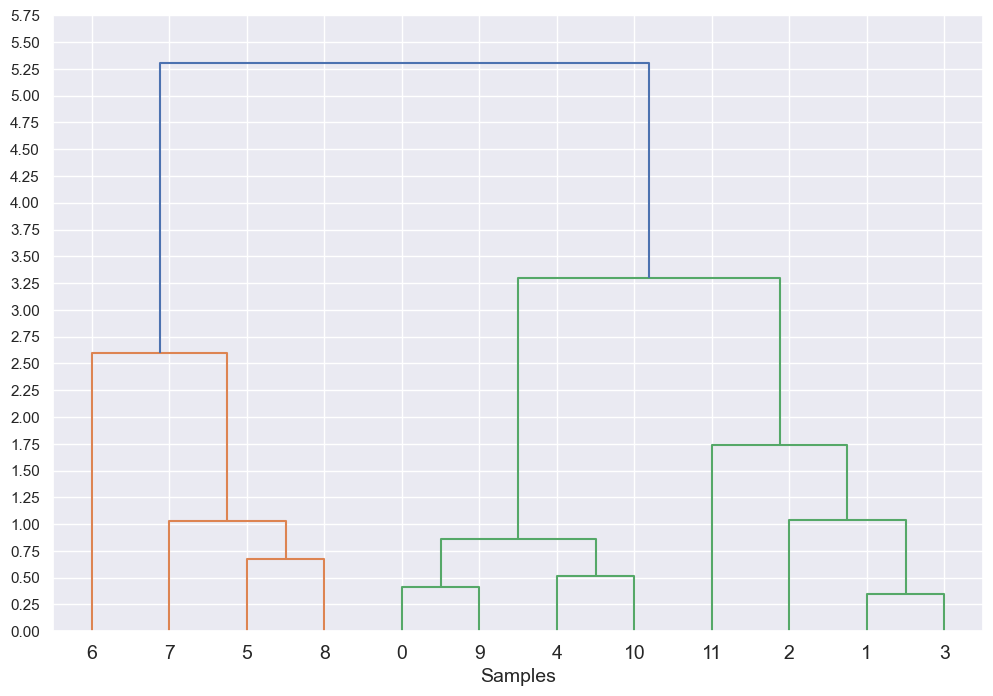

In [5]:
# Show the dendrogram with Ward's linkage
Z = linkage(dm, method='ward')

fig, ax = plt.subplots(figsize=(12, 8))

d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)

ax.set_xlabel('Samples', fontsize=14)
ax.set_yticks(np.arange(0, 6.0, 0.25))

plt.show()

As explained previously, the x axis represents the samples intended to minimize the risk of cross-connections, while the y axis shows the dissimilarity level. Let's now analyze the diagram from the bottom. The initial state corresponds to all samples considered as independent clusters (so the
dissimilarity is null). Moving upward, we start to observe the first mergers. In particular, when the
dissimilarity is about 0.35, samples 1 and 3 are merged.

The second step happens with a dissimilarity of slightly below 0.5, when the samples 0 and 9 are also
merged. The process goes on until a dissimilarity of about 5.25, when a single cluster is created. Let's now dissect the dendrogram horizontally when the dissimilarity is equal to 1.25. Looking at the
underlying connections, we discover that the clustering structure is: {6}, {7, 5, 8}, {0, 9, 4, 10}, {11}, {2, 1, 3}.

Therefore, we have five clusters, with two of them made up of a single sample. It's not surprising to
observe that samples 6 and 11 are the last ones to be merged. In fact, they are much further apart than all the other ones.

Another advantage of dendrograms is the possibility to compare the behavior of different linkage
methods. Using Ward's method, the first mergers happen at quite low dissimilarity levels, but there's a large gap between five clusters and three clusters. This is a consequence of both the geometry and the merging strategy. What happens, for example, if we employ different linkage stratgies? Let's start with single linkage.

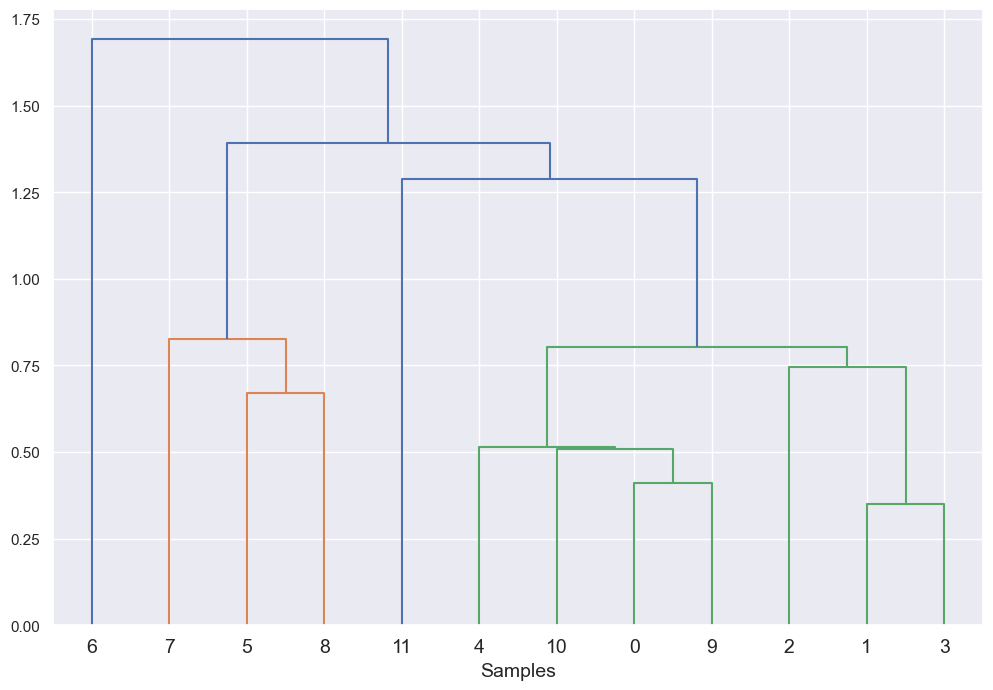

In [6]:
# Show the dendrogram with single linkage
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(12, 8))

d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)

ax.set_xlabel('Samples', fontsize=14)
ax.set_yticks(np.arange(0, 2.0, 0.25))

plt.show()


It's interesting to note that, while Ward's linkage yields a potential optimal number of clusters
(three) by cutting the dendrogram at Level 3.0, single linkage never reaches such a configuration
(because cluster {6} is merged only in the final step). This effect is strictly related to the double
principle of maximum separation and maximum cohesion. Ward's linkage tends to find the most cohesive and separated clusters very quickly. It allows cutting the dendrogram when the dissimilarity gap overcomes a predefined threshold (and, of course, when the desired number of clusters has been reached), while other linkages require a different approach and, sometimes, yield undesirable final configurations.

Considering the nature of the problem, it's always encouraged to test the behavior of all linkage
methods and to find out the most appropriate method for some sample scenarios (for example, the
segmentation of the population of a country according to education level, occupancy, and income). This is the best approach to increase awareness and to improve the ability to provide a semantic
interpretation of the processes (which is a fundamental goal of any clustering procedure).

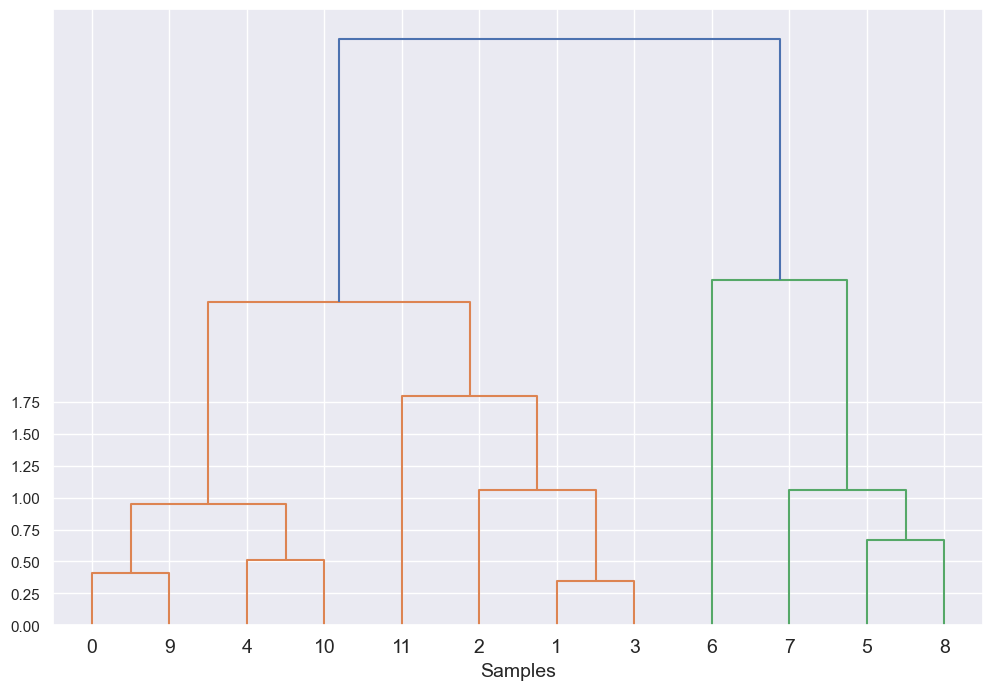

In [7]:
# Show the dendrogram with complete linkage
Z = linkage(dm, method='complete')

fig, ax = plt.subplots(figsize=(12, 8))

d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)

ax.set_xlabel('Samples', fontsize=14)
ax.set_yticks(np.arange(0, 2.0, 0.25))

plt.show()


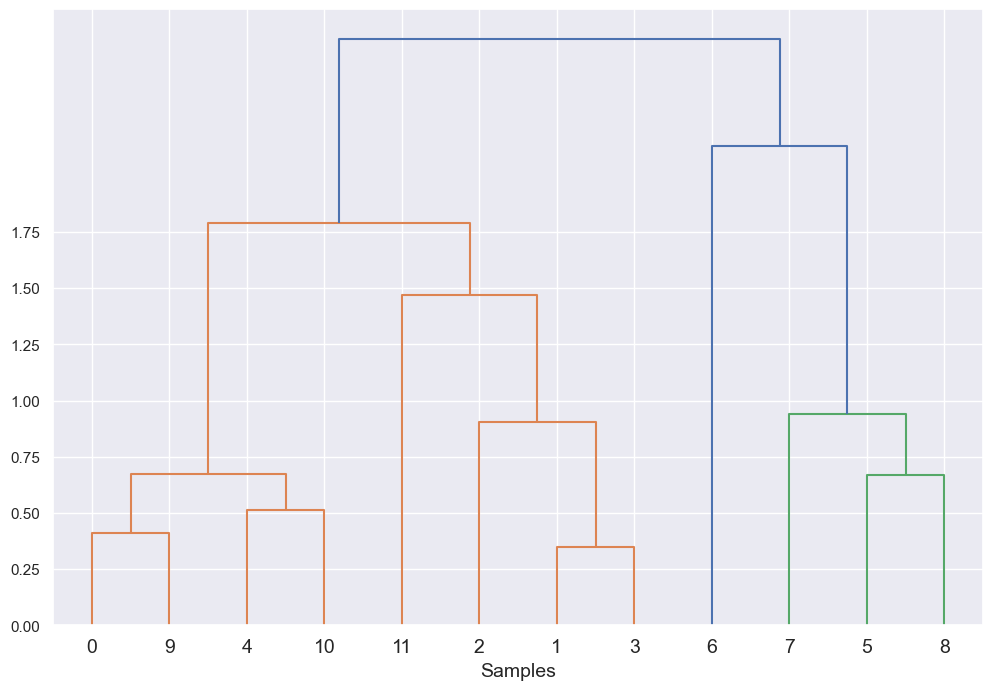

In [8]:
# Show the dendrogram with average linkage
Z = linkage(dm, method='average')

fig, ax = plt.subplots(figsize=(12, 8))

d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)

ax.set_xlabel('Samples', fontsize=14)
ax.set_yticks(np.arange(0, 2.0, 0.25))

plt.show()


## Cophentic correlation as performance metric

Hierarchical clustering performance can be evaluated by using any of the methods previously discussed. However, in this particular case, a specific measure (that doesn't require the ground
truth) can be employed. Given a proximity matrix $M$, and a linkage $L$, a couple of samples, $x^{(i)}$ and $x^{(j)}$, are always assigned to the same cluster at a certain hierarchical level. Of course, it's important to remember that in the agglomerative scenario, we start with $m$ different clusters and we end up with a single cluster equivalent to $X$. Moreover, as two merged clusters become a single one, two samples belonging to a cluster will always continue to belong to the same enlarged cluster until the end of the process.

Considering the first dendrogram shown in the previous section, samples {1} and {3} are immediately
merged; then sample {2} is added, followed by {11}. At this point, the whole cluster is merged with
another block (containing samples {0}, {9}, {4}, and {10}). On the last level, the remaining samples
are merged in order to form a single final cluster. Hence, naming the dissimilarity levels DL0, DL1, ..., and DLk, samples {1} and {3} start belonging to the same cluster at DL1, while, for example, {2} and {1} are found in the same cluster at DL6.

At this point, we can define $DL_{ij}$ as the dissimilarity level at which $x^{(i)}$ and $x^{(j)}$ belong to the same cluster for the first time and the cophenetic matrix denoted as $CP$ in the following (m × m) matrix:

$$ CP_{ij} = [DL_{ij}] $$

In other words, the $CP_{ij}$ element is the smallest dissimilarity needed to observe $x^{(i)}$ and $x^{(j)}$ in the same cluster.

The correlation of the CP matrix it is called **Cophenetic Correlation Coefficient (CPC)** and is a measure of how faithfully a dendrogram preserves the pairwise distances between the original unmodeled data points.

In [9]:
cpc, cp = cophenet(linkage(dm, method='ward'), dm)
print('CPC Ward\'s linkage: {:.3f}'.format(cpc))
cpc, cp = cophenet(linkage(dm, method='single'), dm)
print('CPC Single linkage: {:.3f}'.format(cpc))
cpc, cp = cophenet(linkage(dm, method='complete'), dm)
print('CPC Complete linkage: {:.3f}'.format(cpc))
cpc, cp = cophenet(linkage(dm, method='average'), dm)
print('CPC Average linkage: {:.3f}'.format(cpc))

CPC Ward's linkage: 0.775
CPC Single linkage: 0.771
CPC Complete linkage: 0.779
CPC Average linkage: 0.794


According to CPC the average linkage is the most accurate and should be preferred to the other linkages if there are no specific reasons for skipping it.
The cophenetic correlation is an evaluation metric peculiar to hierarchical clustering and it generally provides reliable outcomes. However, when the geometries are more complex, the CPC value could be misleading and result in sub-optimal configurations. For this reason, I always suggest using other metrics as well (for example, the Silhouette score or the adjusted Rand score) in order to double-check performance and make the most appropriate choices.

## Exercise

Now consider a more detailed problem on a larger dataset containing 527 samples with 38 chemical and physical variables describing the status of water treatment plants. The goal is to find the optimal clustering with an agnostic approach; in other words, we won't consider the semantic labeling process (which needs a domain expert) but only the geometrical structure of the dataset and the relations discovered by the agglomerative algorithm.

The first column is an index related to the specific plant, while all the other values are numeric and can be converted to float64. The missing values are indicated with the '?' character and, as we don't have any other pieces of information, they are set with the mean of each attribute:

In [10]:
# Read the dataset
data_path = 'water-treatment.data'
df = pd.read_csv(data_path, header=None, index_col=0, na_values='?').astype(np.float64)
df.fillna(df.mean(), inplace=True)

c:\Users\hageo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hageo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


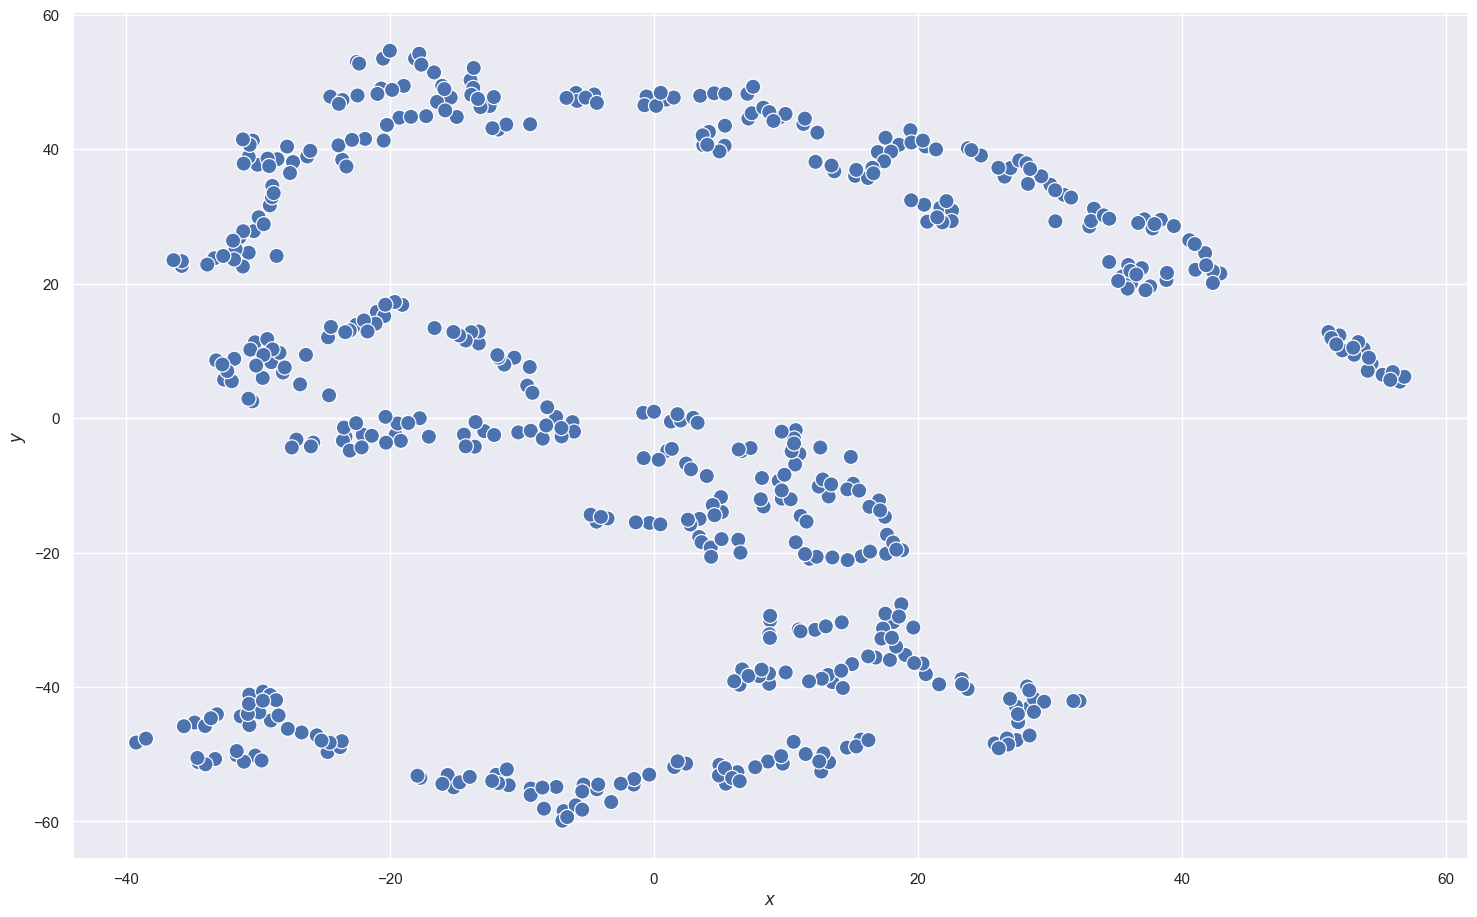

In [11]:
# Standardize the dataset
ss = StandardScaler(with_std=False)
sdf = ss.fit_transform(df)

# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(sdf)

df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([df, df_tsne], axis=1)

# Show the dataset
sns.set()

fig, ax = plt.subplots(figsize=(18, 11))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',
                    y='y',
                    size=0,
                    sizes=(120, 120),
                    data=dff,
                    legend=False,
                    ax=ax)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()


**Instructions:**

Perform agglomerative clustering for all the combinations of number of clusters and linkage methods stated in the next cell. Use Euclidean as distance metric.

For each combination keep the CPC and Silhouette scores and plot the corresponding dendrogram (truncated to 80 samples).

Based on the scores, select the best combination and plot the data points identifying the clusters by color.

Documentation:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [12]:
nb_clusters = [4, 6, 8, 10]
linkages = ['single', 'complete', 'ward', 'average']

In [13]:
# Analyze the result of different linkages and number of clusters
cpcs = np.zeros(shape=(len(linkages), len(nb_clusters)))
silhouette_scores = np.zeros(shape=(len(linkages), len(nb_clusters)))

c:\Users\hageo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hageo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


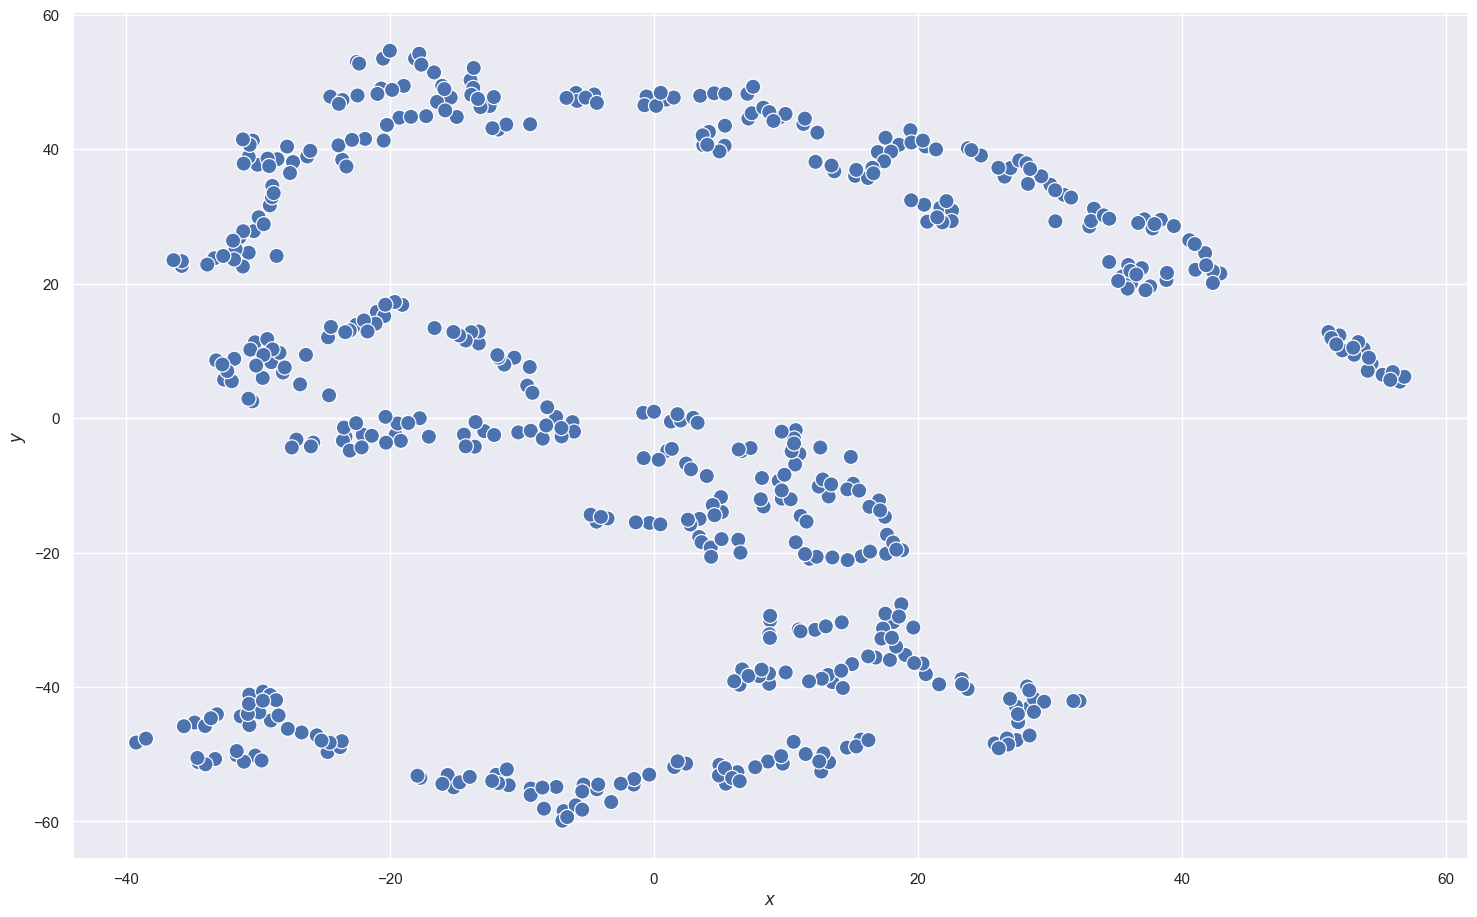

In [14]:
# Read the dataset
data_path = 'water-treatment.data'
df = pd.read_csv(data_path, header=None, index_col=0, na_values='?').astype(np.float64)
df.fillna(df.mean(), inplace=True)

# Standardize the dataset
ss = StandardScaler(with_std=False)
sdf = ss.fit_transform(df)

# Perform the TSNE non-linear dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(sdf)

df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=df.index)
dff = pd.concat([df, df_tsne], axis=1)

# Show the dataset
sns.set()

fig, ax = plt.subplots(figsize=(18, 11))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',
                    y='y',
                    size=0,
                    sizes=(120, 120),
                    data=dff,
                    legend=False,
                    ax=ax)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()

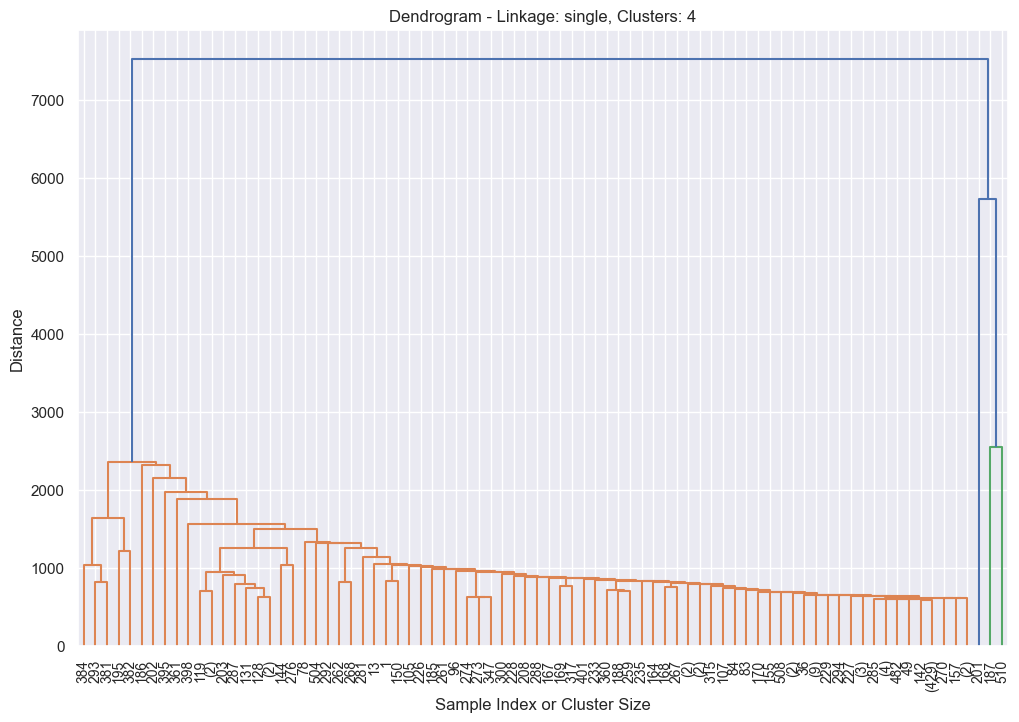

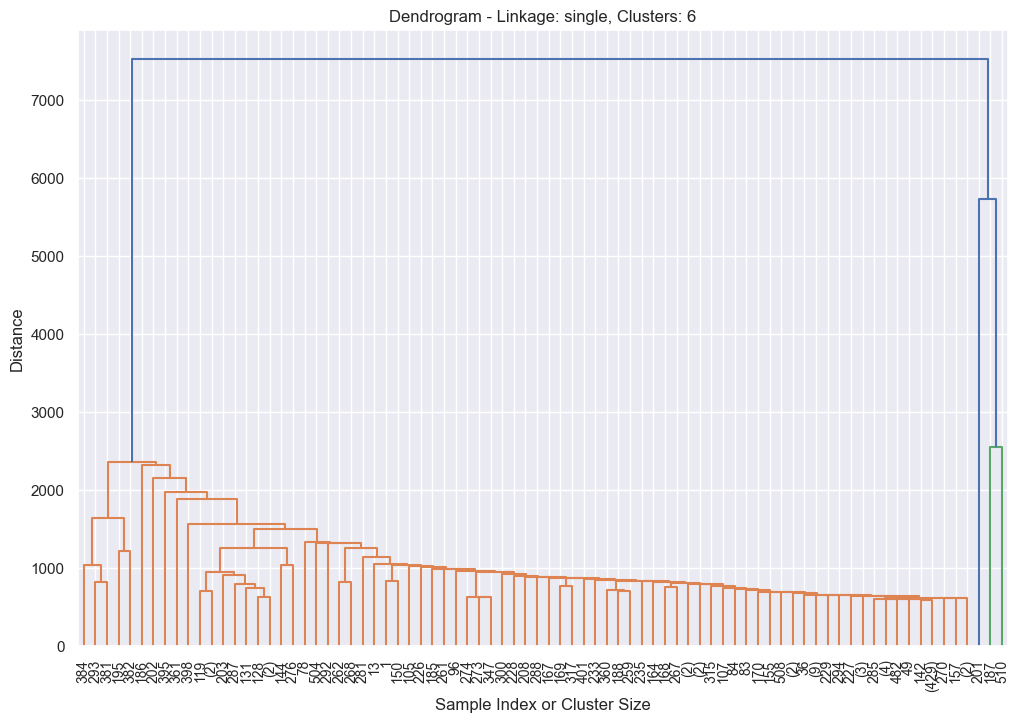

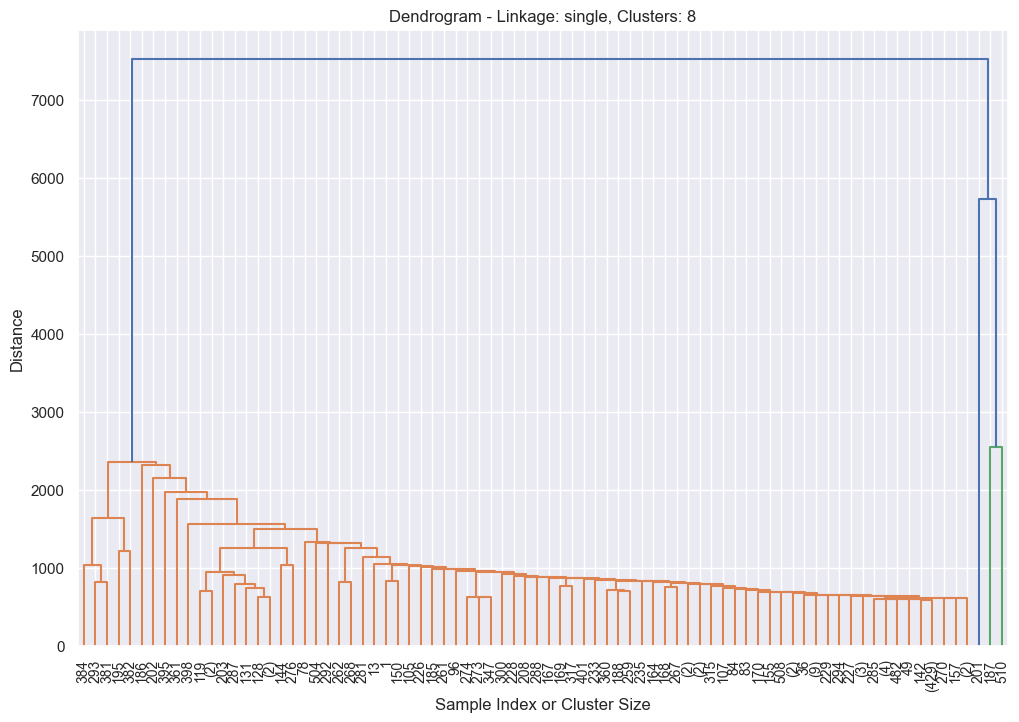

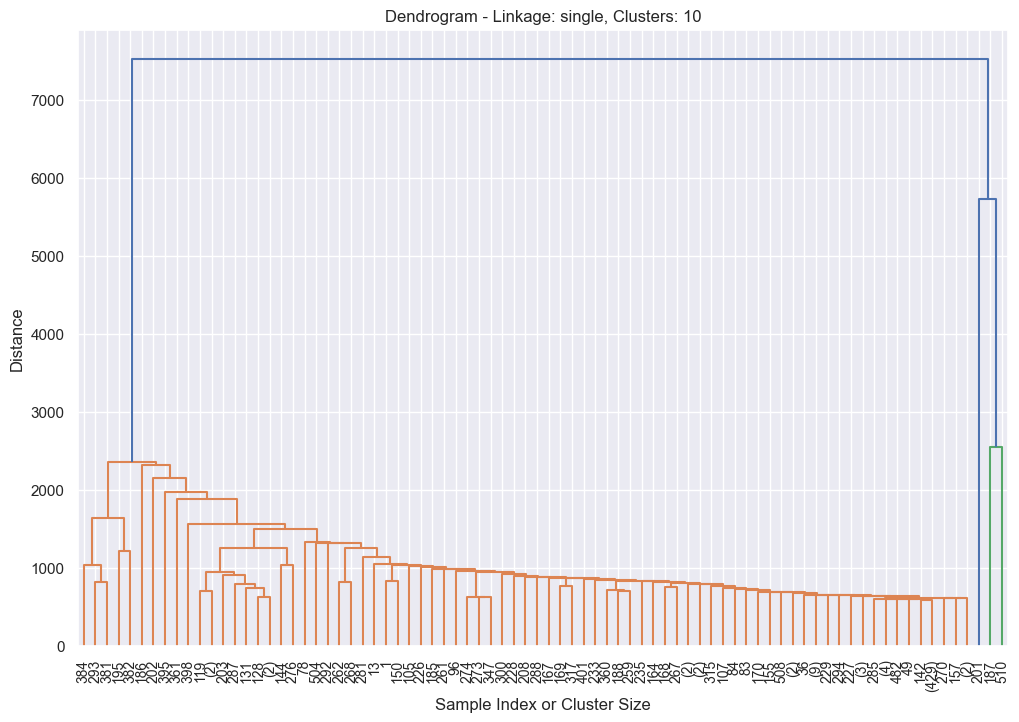

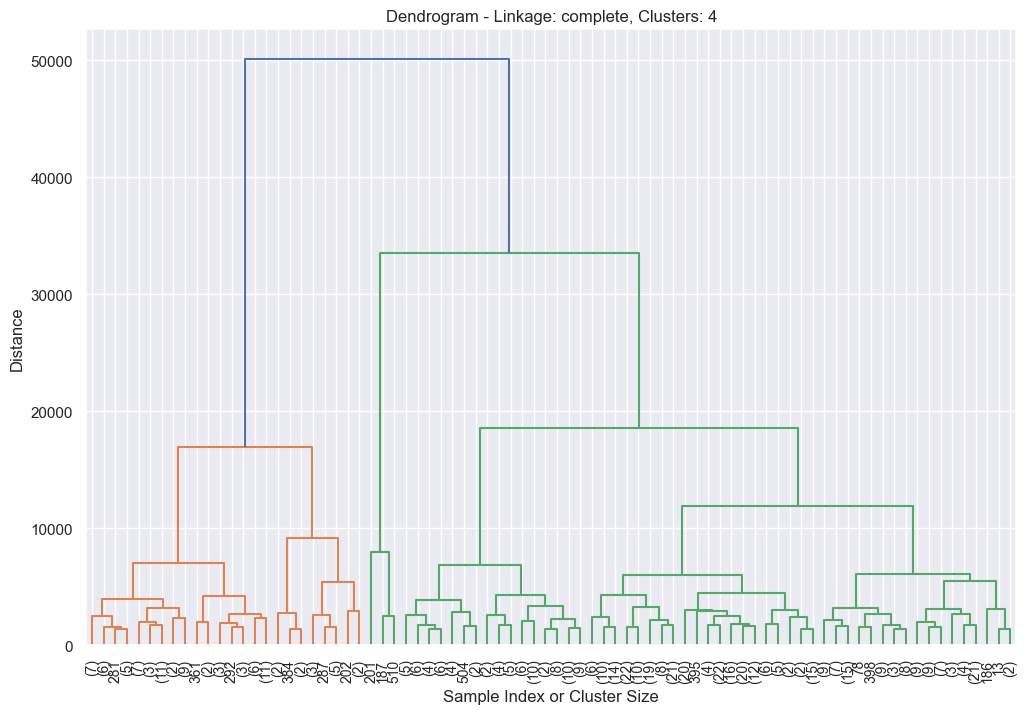

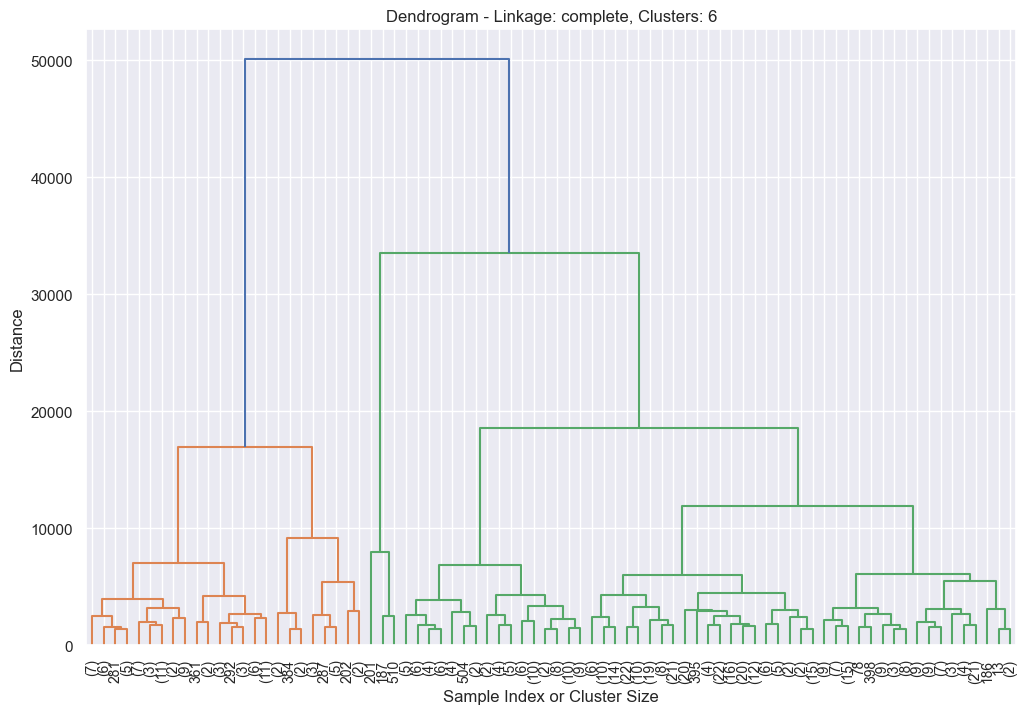

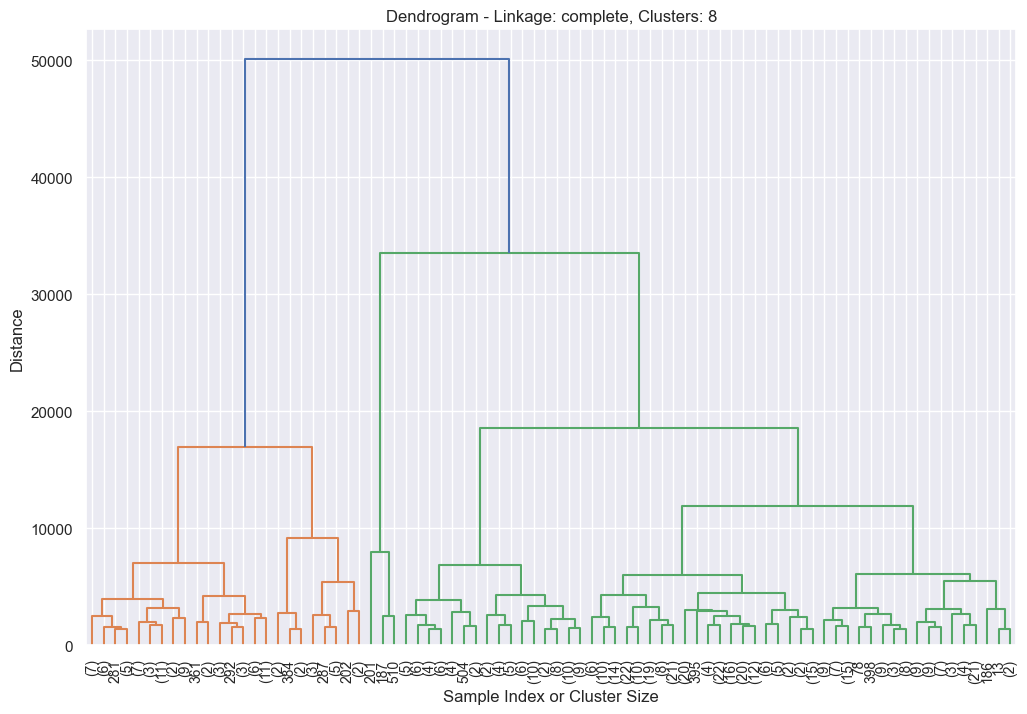

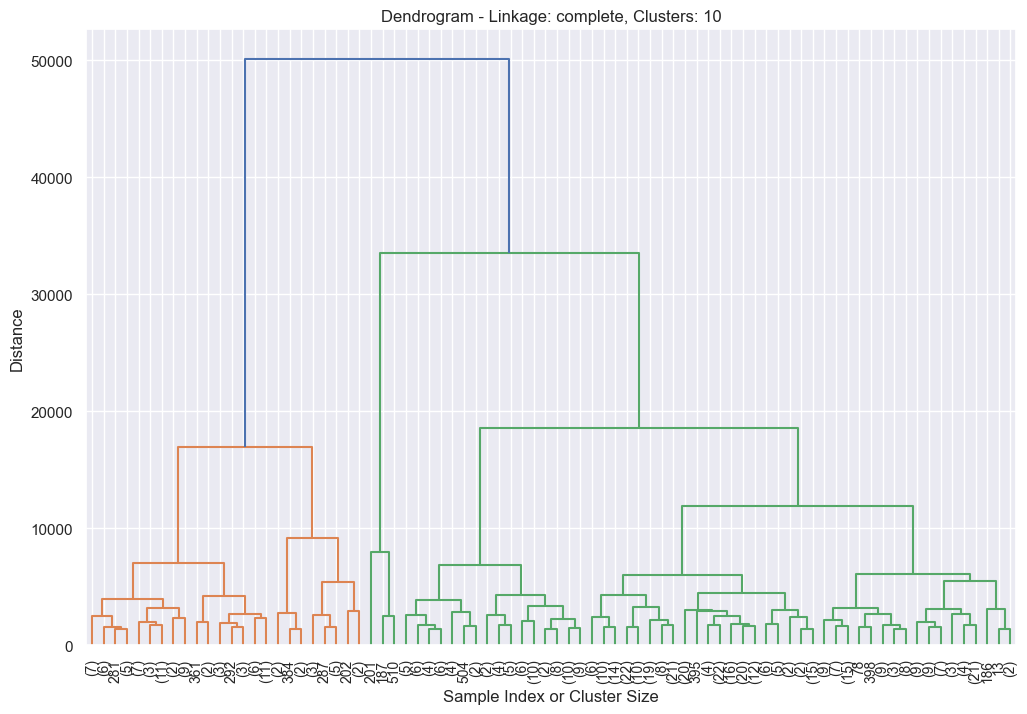

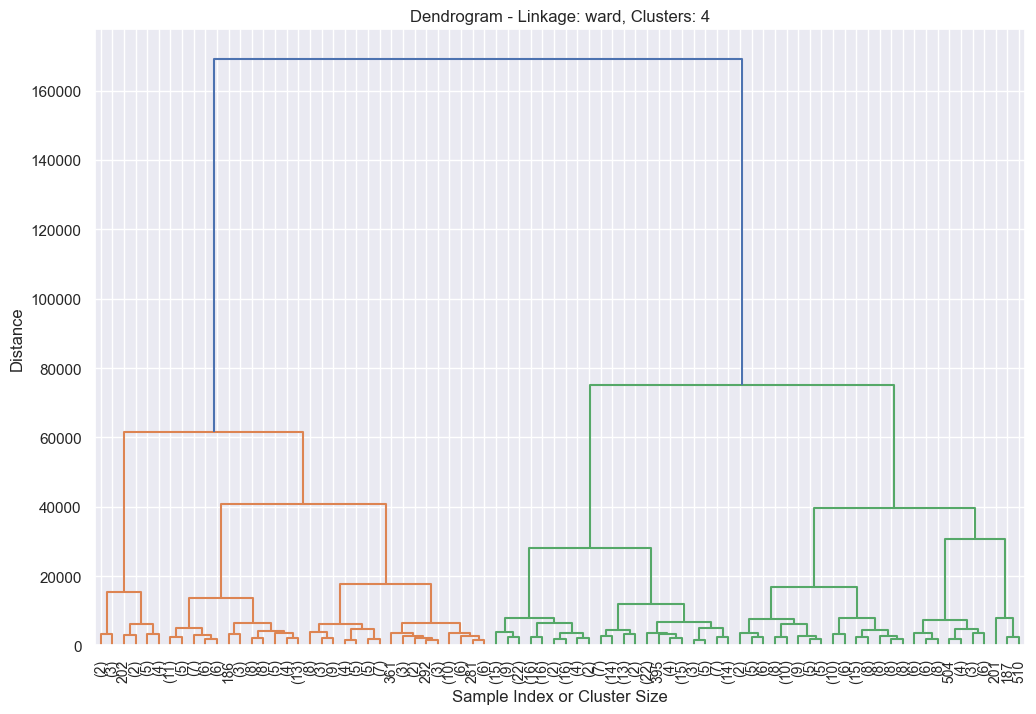

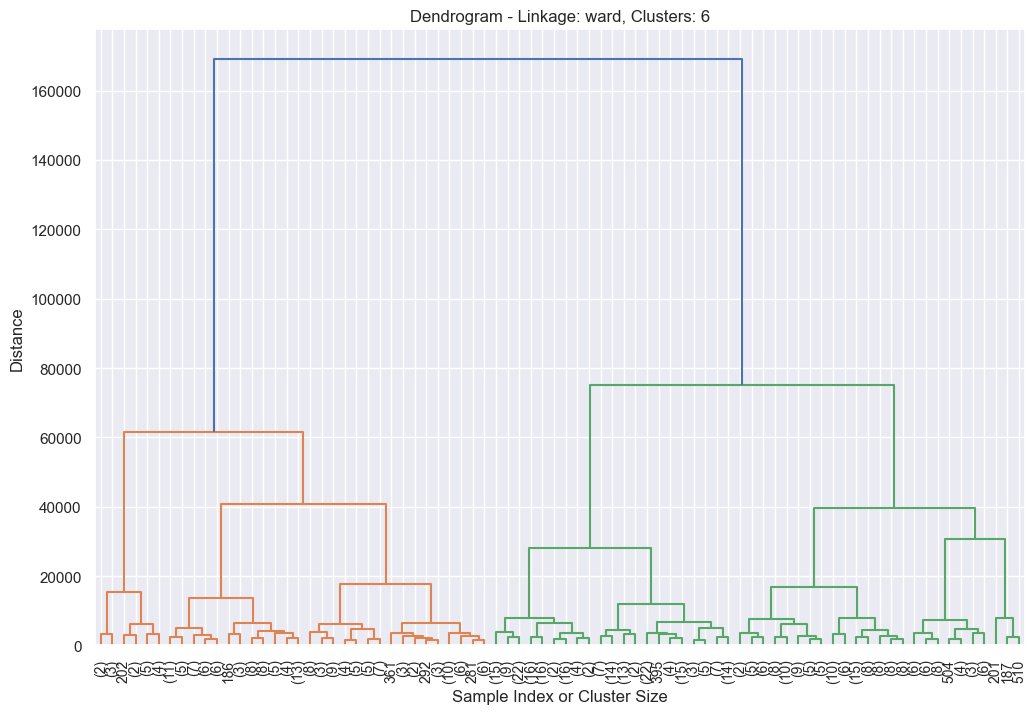

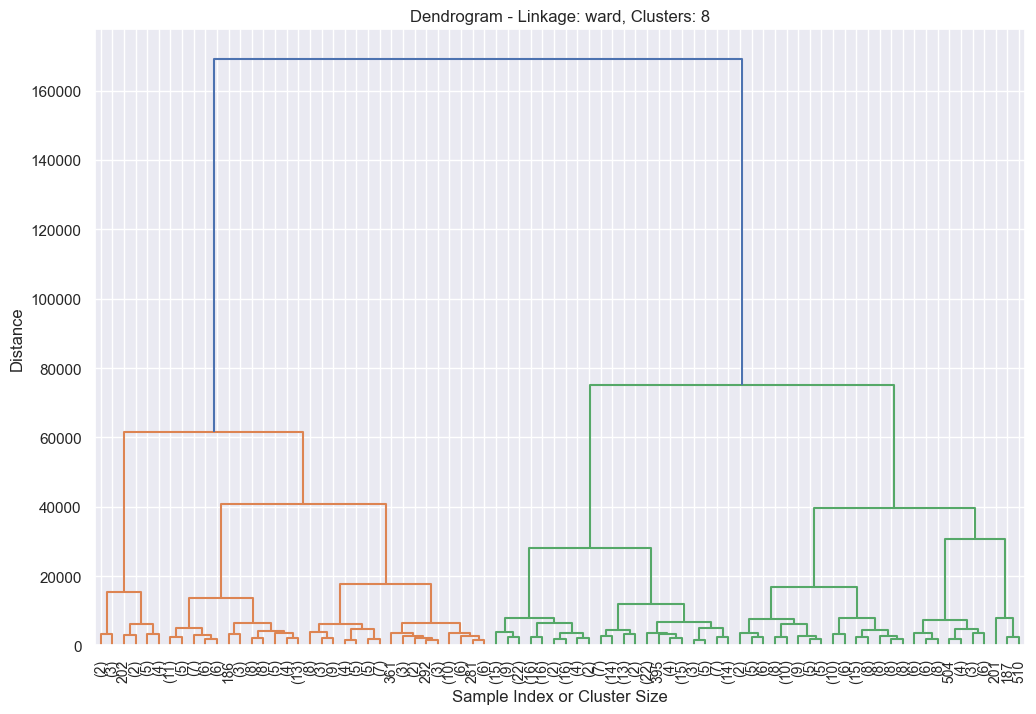

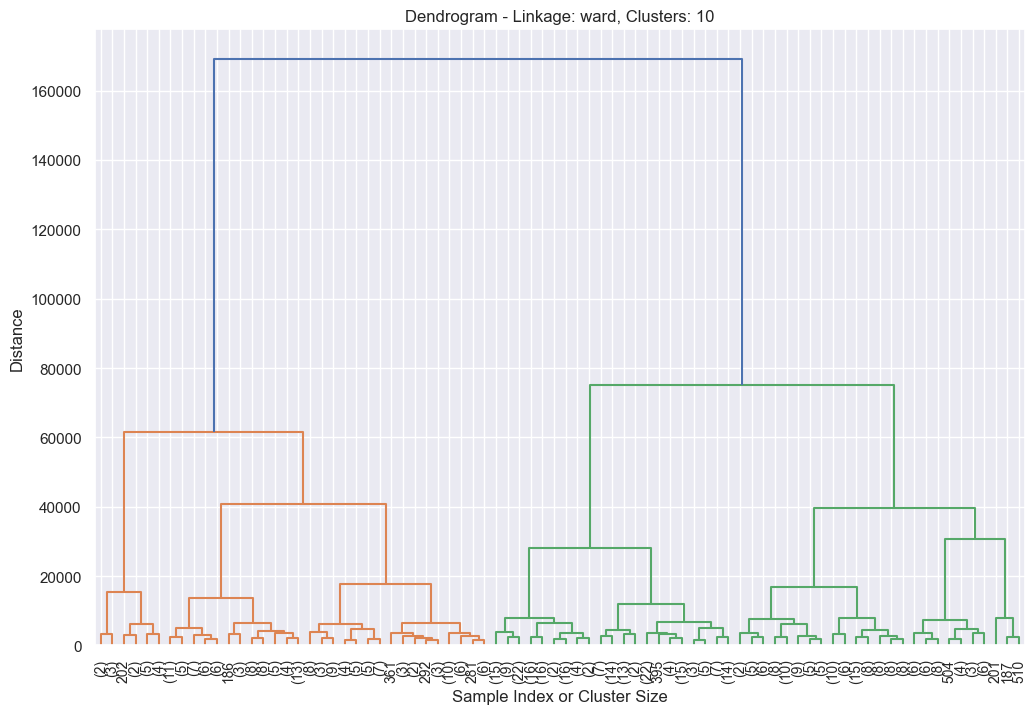

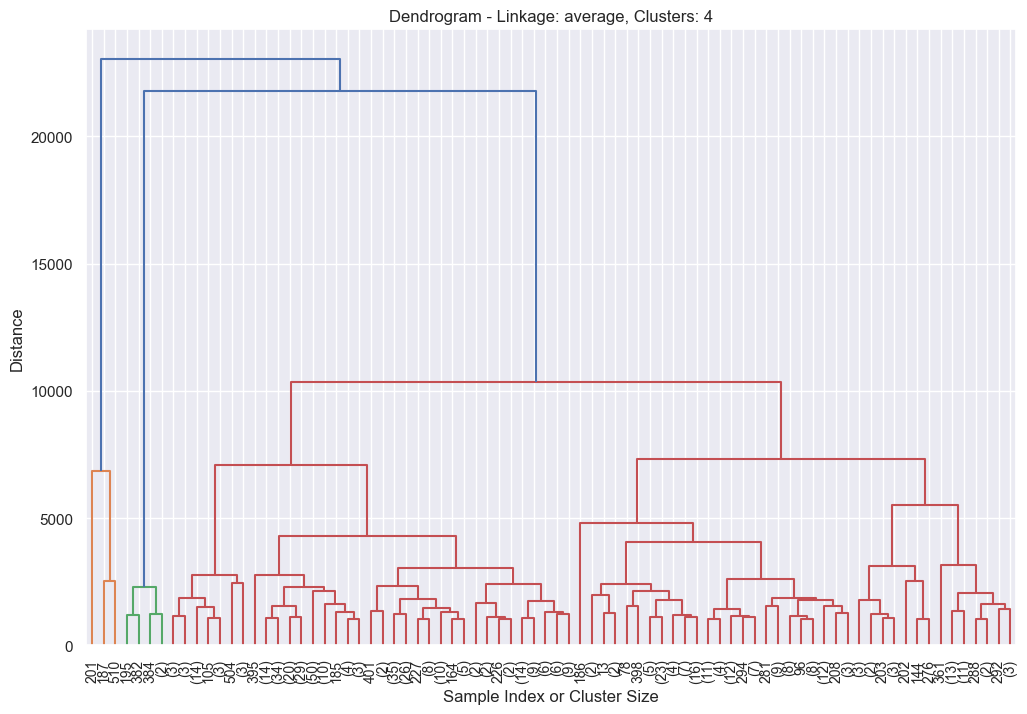

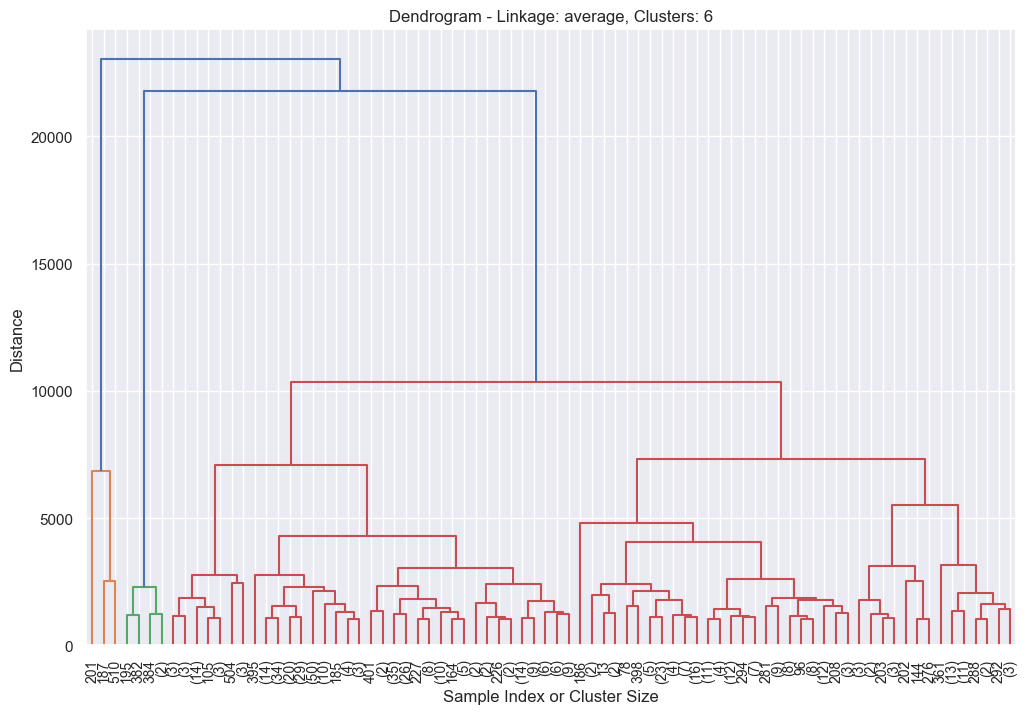

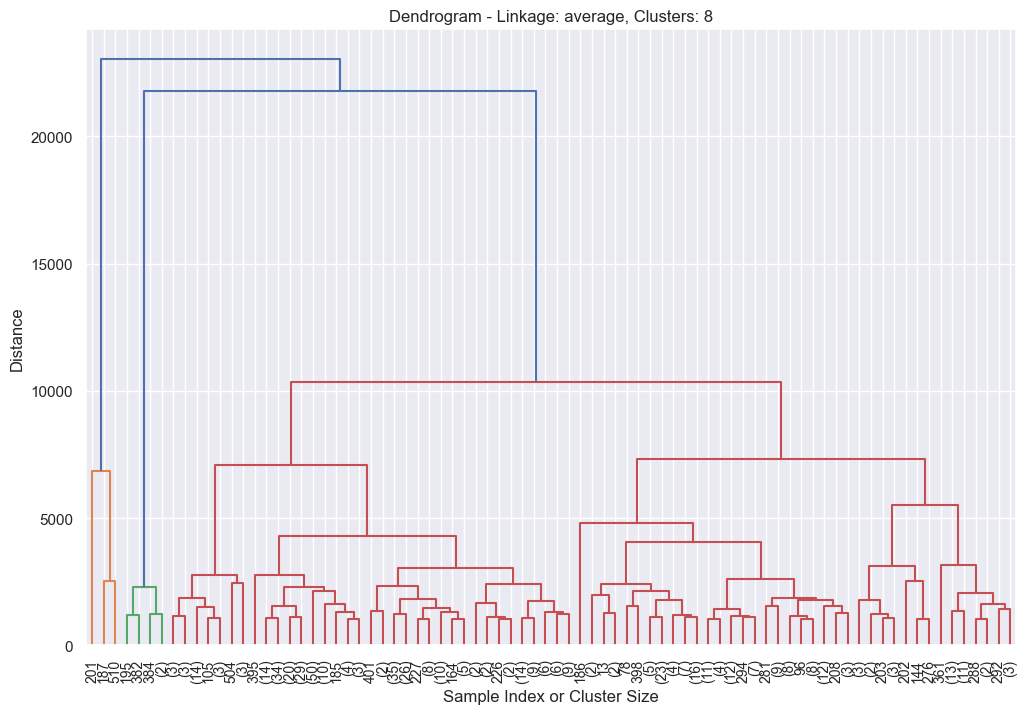

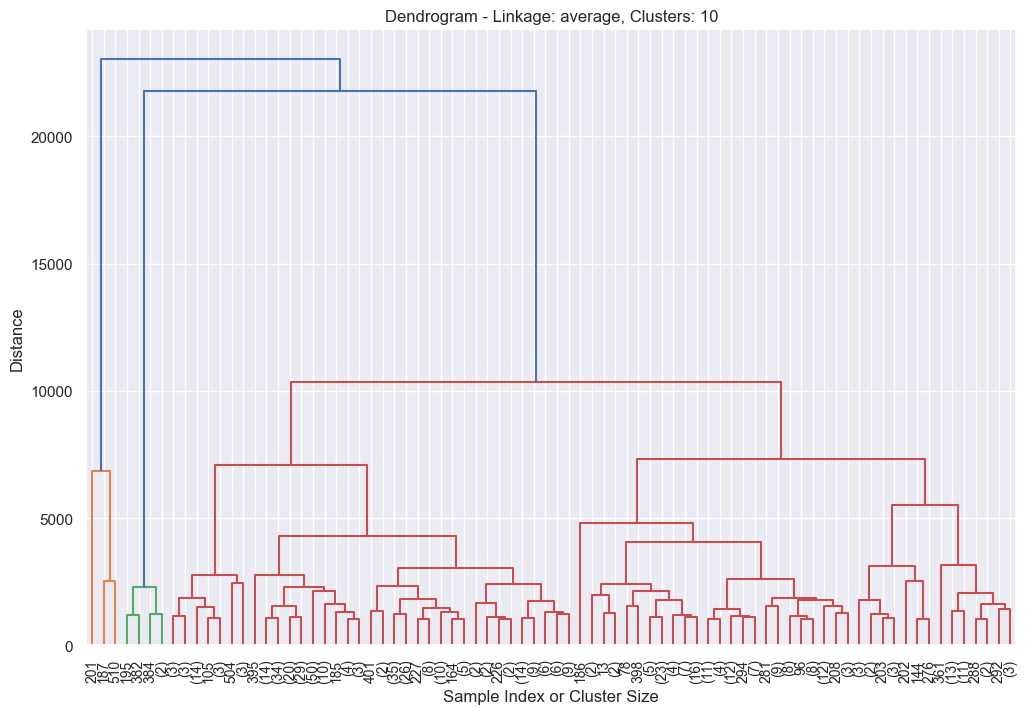

In [15]:
# Analyze the result of different linkages and number of clusters
nb_clusters = [4, 6, 8, 10]
linkages = ['single', 'complete', 'ward', 'average']
cpcs = np.zeros(shape=(len(linkages), len(nb_clusters)))
silhouette_scores = np.zeros(shape=(len(linkages), len(nb_clusters)))

for i, linkage_method in enumerate(linkages):
    for j, n_clusters in enumerate(nb_clusters):
        # Perform Agglomerative Clustering
        agglom = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, affinity='euclidean')
        cluster_labels = agglom.fit_predict(sdf)
        
        # Compute the distance matrix
        dm = pdist(sdf, metric='euclidean')
        
        # Compute the Cophenetic Correlation Coefficient (CPC)
        Z = linkage(dm, method=linkage_method)
        cpc, _ = cophenet(Z, dm)
        cpcs[i, j] = cpc
        
        # Compute the Silhouette score
        silhouette_avg = silhouette_score(sdf, cluster_labels)
        silhouette_scores[i, j] = silhouette_avg
        
        # Plot the dendrogram (truncated to 80 samples)
        fig, ax = plt.subplots(figsize=(12, 8))
        d = dendrogram(Z, truncate_mode='lastp', p=80, show_leaf_counts=True, leaf_font_size=10, ax=ax)
        ax.set_title(f'Dendrogram - Linkage: {linkage_method}, Clusters: {n_clusters}')
        ax.set_xlabel('Sample Index or Cluster Size')
        ax.set_ylabel('Distance')
        plt.show()

# Display CPC and Silhouette Scores
cpc_df = pd.DataFrame(cpcs, index=linkages, columns=nb_clusters)
silhouette_df = pd.DataFrame(silhouette_scores, index=linkages, columns=nb_clusters)

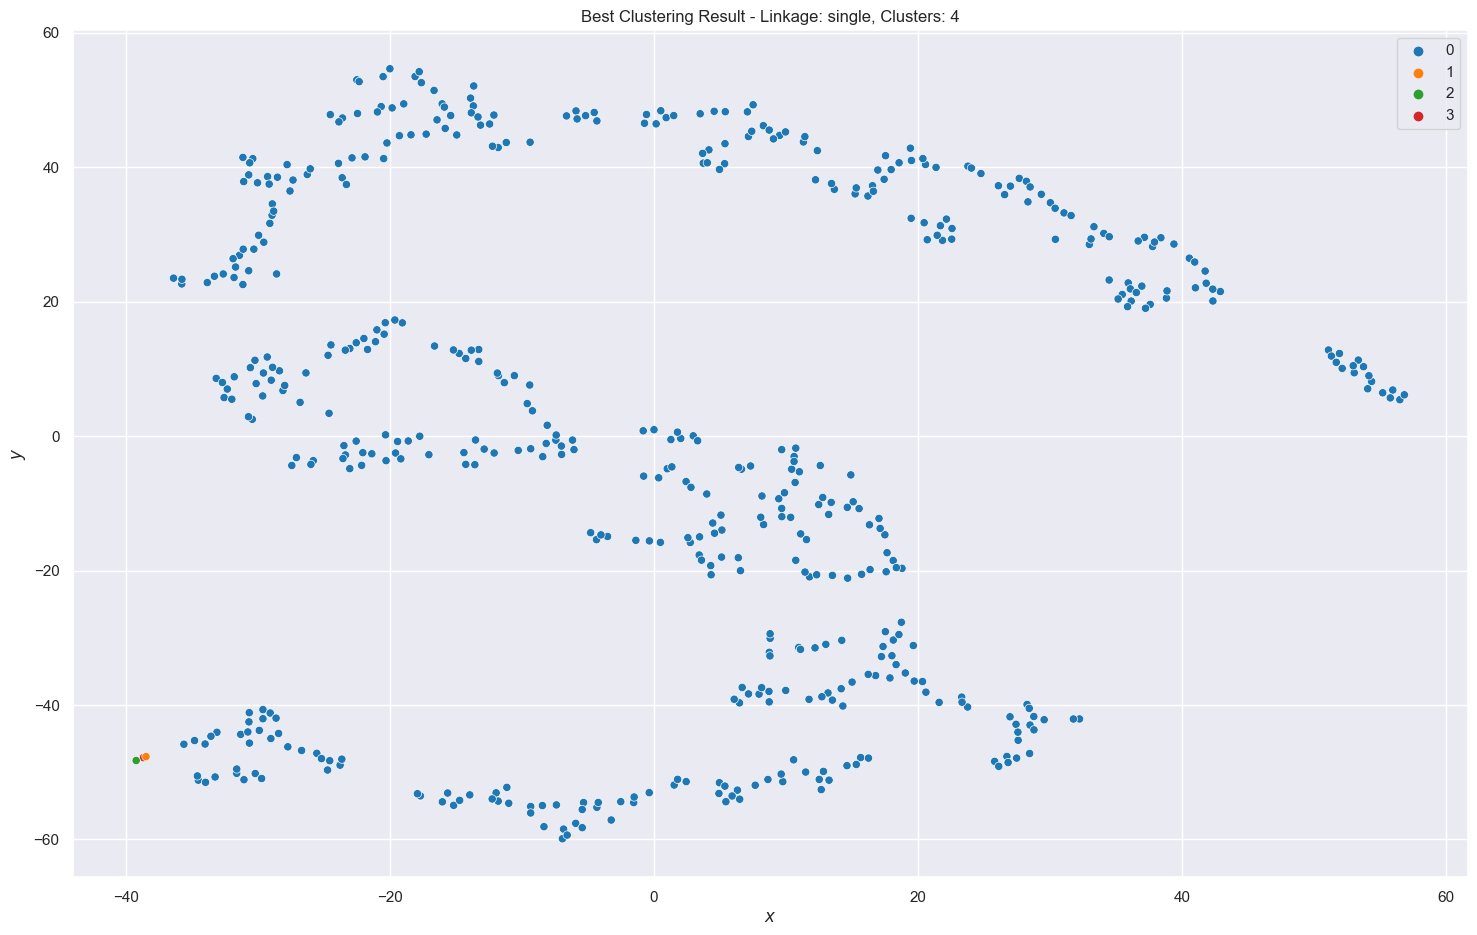

In [17]:
# Find the best combination based on the highest Silhouette score
best_linkage_idx, best_cluster_idx = np.unravel_index(np.argmax(silhouette_scores), silhouette_scores.shape)
best_linkage = linkages[best_linkage_idx]
best_n_clusters = nb_clusters[best_cluster_idx]

# Perform the best clustering
best_agglom = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, affinity='euclidean')
best_cluster_labels = best_agglom.fit_predict(sdf)

# Plot the clustering result
fig, ax = plt.subplots(figsize=(18, 11))

sns.scatterplot(x='x', y='y', hue=best_cluster_labels, palette='tab10', data=dff, legend='full', ax=ax)
ax.set_title(f'Best Clustering Result - Linkage: {best_linkage}, Clusters: {best_n_clusters}')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()